#  *MANDELBROT* 

## Zadanie 2p
 1. Dokonaj przekształcenia plików z wygenerowanymi fraktalami do postaci plików graficznych,
 które wyświetlisz.
 2. Przedstaw na wykresach porównanie czasów wykonania programów na GPU (Colab) oraz
 CPU (Colab oraz komputer stacjonarny) w zależności od rozmiaru problemu (stała DIM). W
 optymalnym przypadku wykresy powinny zostać zrealizowane z matplotlib i dołączone do
 Colab.
 3. Punkty 1,2 zrealizuj dla fraktala Mandelbrota.
 4. Zrealizuj pracę w postaci sprawozdania w Google Colab – dokonaj także opisu programów i
 zrealizowanych czynności – ma to mieć postać tutoriala dla osoby, która nie na związku z
 przedmiotem

In [6]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-r9zuk9zf
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-r9zuk9zf
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin



 # Na CPU


#opis programu

 
 Struktura "cuComplex" do przechowywania liczb zespolonych: Ta struktura jest używana do reprezentacji liczb zespolonych i zawiera składowe rzeczywistą i urojoną. Struktura zawiera również kilka funkcji takie jak "magnitude2", "operator *" i "operator +", które są używane do obliczania wartości liczby zespolonej.

Funkcja "mandelbrot2": Ta funkcja jest głównym algorytmem generującym fraktal. Funkcja ta przyjmuje argumenty "x" i "y" wskazujące położenie punktu na płaszczyźnie liczb zespolonych. Algorytm iteruje po liczbie zespolonej zgodnie z regułami zbioru Mandelbrota i zwraca wartość 1, jeśli liczba zespolona należy do zbioru, lub 0 w przeciwnym przypadku.

Funkcja "kernel": Ta funkcja jest wykonywana dla każdego punktu na płaszczyźnie liczb zespolonych. Dla każdego punktu funkcja wywołuje funkcję "mandelbrot2", aby sprawdzić, czy punkt należy do zbioru Mandelbrota. Wartość ta jest następnie używana do ustawienia koloru dla punktu na bitmapie.

Funkcja "save_to_file": Ta funkcja zapisuje bitmapę do pliku o nazwie "MandelCPU.ppm" w formacie PPM.

Funkcja "main": Ta funkcja jest główną funkcją programu i odpowiada za inicjalizację danych, wywołanie funkcji "kernel" i zapis do pliku. Czas wykonywania kodu jest również mierzony i wyświetlany na ekranie.

In [7]:
%%cu
#include<stdio.h>
#include <time.h>
#define DIM 2000




struct cuComplex {
    float   r;
    float   i;
    cuComplex( float a, float b ) : r(a), i(b)  {}
    float magnitude2( void ) { return r * r + i * i; }
    cuComplex operator*(const cuComplex& a) {
        return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
    }
    cuComplex operator+(const cuComplex& a) {
        return cuComplex(r+a.r, i+a.i);
    }
};



int mandelbrot2(double x, double y) {
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex z(0, 0);
    for (int i = 0; i < 200; i++) {
    z = z * z + c;
      if (z.magnitude2() > 1000) {
        return 0;
    }
  }
  return 1;
}


void kernel( unsigned char *ptr ){
    for (int y=0; y<DIM; y++) {
        for (int x=0; x<DIM; x++) {
            int offset = x + y * DIM;
            int mandelbrotValue = mandelbrot2( x, y );
            ptr[offset*4 + 0] = 19;
            ptr[offset*4 + 1] = 255 * mandelbrotValue ;
            ptr[offset*4 + 2] = 72;
            ptr[offset*4 + 3] = 200;
        }
    }
 }

struct DataBlock{
    unsigned char *dev_bitmap; 
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("MandelCPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main( void ) {
       clock_t start_time = clock();

    DataBlock data ; 
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM * DIM * 4 ;
    kernel(bitmap);
    save_to_file(bitmap);
    // Record the end time
    clock_t end_time = clock();

    // Calculate the elapsed time in milliseconds
    double elapsed_time = (double)(end_time - start_time) / CLOCKS_PER_SEC * 1000;

    printf("milliseconds %f \n", elapsed_time);
    long milliseconds = elapsed_time ; 
    // Convert the milliseconds to seconds
    long seconds = milliseconds / 1000.0;
    // Print the result
    printf("%d seconds\n",  seconds);


    return 0;

}

milliseconds 6514.253000 
6 seconds



# Na GPU

In [8]:
%%cu
#include<stdio.h>
#define DIM 2000
#include <cuda_runtime.h>

struct cuComplex {
    float   r;
    float   i;
    // cuComplex( float a, float b ) : r(a), i(b)  {}
    __device__ cuComplex( float a, float b ) : r(a), i(b) {} // Fix error for calling host function from device
    __device__ float magnitude2( void ) {
        return r * r + i * i;
    }
    __device__ cuComplex operator*(const cuComplex& a) {
        return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
    }
    __device__ cuComplex operator+(const cuComplex& a) {
        return cuComplex(r+a.r, i+a.i);
    }
};


__device__ int mandelbrot2(double x, double y) {
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex z(0, 0);
    for (int i = 0; i < 200; i++) {
    z = z * z + c;
      if (z.magnitude2() > 1000) {
        return 0;
    }
  }
  return 1;
}


__global__ void kernel( unsigned char *ptr ) {
    // map from blockIdx to pixel position
    int x = blockIdx.x;
    int y = blockIdx.y;
    int offset = x + y * gridDim.x;

    // now calculate the value at that position
    int man =  mandelbrot2( x, y );
    ptr[offset*4 + 0] = 150;
    ptr[offset*4 + 1] = 220;
    ptr[offset*4 + 2] = 177 * man;
    ptr[offset*4 + 3] = 12;
}

// globals needed by the update routine
struct DataBlock {
    unsigned char   *dev_bitmap;
};



void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("MandelGPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}

int main( void ) {
    // Create the start and end events
    cudaEvent_t start, end;
    cudaEventCreate(&start);
    cudaEventCreate(&end);

    // Record the start time
    cudaEventRecord(start, 0);

    
    DataBlock data ; 
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM * DIM * 4 ;
    unsigned char *dev_bitmap;
    cudaMalloc((void**)&dev_bitmap,image_size);
    data.dev_bitmap = dev_bitmap ;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost) ;   
    cudaFree(dev_bitmap);
    save_to_file(bitmap);
       // Record the end time
    cudaEventRecord(end, 0);

    // Synchronize the stream to wait for the kernel to finish
    cudaEventSynchronize(end);

    // Calculate the elapsed time
    float elapsed_time;
    cudaEventElapsedTime(&elapsed_time, start, end);

    // Print the elapsed time in milliseconds
    printf("Elapsed time: %f milliseconds\n", elapsed_time);

    // Destroy the events
    cudaEventDestroy(start);
    cudaEventDestroy(end);


}

Elapsed time: 708.795471 milliseconds



# wykres

 Tworzy wykres porównujący czas wykonywania operacji na procesorze (CPU) i na karcie graficznej (GPU) w zależności od rozmiaru danych (DIM). Kolor niebieski oznacz CPU, czerwony GPU





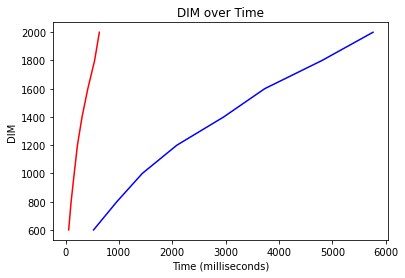

In [9]:
import matplotlib.pyplot as plt

# dodanie do tablic wartosci time i dim  
time_ms_cpu = [ 525.729000 , 962.112000  , 1438.720000   , 2086.150000  , 2963.573000 , 3731.129000  , 4805.774000  , 5761.879000 ]
dim_cpu = [600 , 800 , 1000 , 1200 , 1400 , 1600 , 1800 , 2000  ]

time_ms_GPU = [ 59.203777  ,105.271072   ,163.239304 ,223.393799  ,309.888153  ,417.935242  ,545.383118   ,634.012207 ]
dim_GPU = [600 , 800 , 1000 , 1200 , 1400 , 1600 , 1800 , 2000]

# stowrzenie wykresu funkcja plot
plt.plot(time_ms_cpu, dim_cpu, color='blue', label='CPU')
plt.plot(time_ms_GPU ,dim_GPU  , color='red' , label='GPU' )

# tytyl , os x i y 
plt.xlabel('Time (milliseconds)')
plt.ylabel('DIM')
plt.title('DIM over Time')

# pokaz wykres 
plt.show()